<img src = "https://escp.eu/sites/default/files/logo/ESCP-logo-white-misalign.svg" width = 400 style="background-color: #240085;">
<h1 align=center><font size = 6>ESCP Business School</font></h1>
<h3 align=center><font size = 5>SCOR Datathon</font><br/>
<font size = 3>The Data Science Challenge Bridging Indian Agricultureal Protection Gap</font></h3>
<h6 align=center>Chapter 3A - Data Preparation for Clustering (Free Level)</h6>

Last Updated: December 15, 2021\
Author: Group 21 - Anniek Brink, Jeanne Dubois, and Resha Dirga

<h3>Chapter Objectives</h3>

<p>This chapter aims to prepare the dataset for clustering. There are <b><u>three</u></b> steps that we are going to perform on this chapter:</p>

<ul>
    <li>Final data imputation and dataset aggregatioin on defined granularity level</li>
    <li>Threshold Yield and Loss Calculation</li>
    <li>Variable selection and scaling</li>
</ul>

<p><i><u>Note:</u> a user need to define the granularity level of which the clustering will be performed.</i></p>

<h3>Chapter 1: Import modules</h3>
<p>This chapter lists all modules that being used on this document. The module import process will be performed on this chapter</p>

In [1]:
import numpy as np
import pandas as pd

from sklearn import preprocessing

import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler

<h3>Chapter 2: Data loading and the selection of granularity level and yield features selection</h3>
<p>This chapter reads the data and prepares the necessary variables and functions for the data preparation. User needs to determine at which granularity level the clustering will be performed and which yield features will be included on the threshold yield and loss calculation.</p>

In [2]:
# List of file directories
checkpoint_preprocessed_filenames = [
    "datasets_preprocessed/df_kharif_preprocessed_checkpoint_3.csv",
    "datasets_preprocessed/df_rabi_preprocessed_checkpoint_3.csv"
]

In [3]:
# Store datasets in a dataframe
df = {}
for filename in checkpoint_preprocessed_filenames:
    df[filename] = pd.read_csv(filename, delimiter=";",index_col = 0)

/Users/admin/opt/anaconda3/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3172: DtypeWarning: Columns (5,6) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


In [4]:
# Create a function for indexing the specific dataset
def df_shorten(season):
    if season == "kharif":
        return df[list(df.keys())[0]]
    elif season == "rabi":
        return df[list(df.keys())[1]]
    else:
        print("Data is out of range. Available season data: kharif, rabi (case sensitive)")
        return

In [5]:
# Threshold Yield and Loss Calculation Formula
def ThresholdYield(yields, indemnity):
    yield_list = yields[yield_features].tolist()
    yield_list.sort()
    yield_list = yield_list[2:]
    
    return (sum(yield_list)*indemnity/5)


def LossCalculation(x, yields, sum_insured, threshold_yield):
    
    if threshold_yield != 0:
        yield_list = yields[yield_features].tolist()
        yield_list = yield_list[len(yield_list)-x:]
        yield_list = [max(0, (threshold_yield - y))/threshold_yield for y in yield_list]
    else:
        yield_list = [0]
        
    return (sum(yield_list)*sum_insured)

In [6]:
# Define granularity levels for clustering
granularity_features = ['State', 'Cluster', 'District', 'Sub-District', 'Block', 'GP']
most_granular_level = 'District'

# Define yields to consider on threshold yield and loss calculation
yield_features = ['2010 Yield', '2011 Yield', '2012 Yield', '2013 Yield', '2014 Yield', '2015 Yield', '2016 Yield']

# Define variables to store external data variables columns
additional_data = df_shorten("kharif").columns.to_list()[35:]

In [7]:
# Add identifier for groups by district
for season in ["kharif", "rabi"]:
    ID_features = granularity_features[0:granularity_features.index(most_granular_level)+1]
    df_shorten(season)['Group'] = ''

    for column in ID_features:
        df_shorten(season)['Group'] = df_shorten(season)['Group'] + "_" + df_shorten(season)[column].map(str)


<h3>Chapter 3: Dataset preparation for clustering</h3>
<p>This chapter performs the three steps in preparing dataset as defined in the Chapter Objective.</p>

<h5>Chapter 3.1 - Final data imputation and dataset aggregatioin on defined granularity level</h5>
<p>After the preprocessing step, there are still some missing values on 'Sum Insured' and yield columns that about to be used on the Threshold Yield and Loss Calculation:</p>
<ul>
    <li>for 'Sum Insured' column, we assume that the null values mean that the location was not insured. Thus, to nulify the value, we will impute the value 0 on the null values</li>
    <li>for the yield columns, we will average the value on the defined granularity since, based on the Glossary, this method is also used on some '20xx Yield' columns</li>
</ul>

In [8]:
# Impute nan values on Sum Insured with 0
for season in ["kharif", "rabi"]:
    df_shorten(season)['Sum Insured (Inr)'] = df_shorten(season)['Sum Insured (Inr)'].fillna(0)

In [9]:
# Impute nan values on yield columns with average
for season in ["kharif", "rabi"]:
    for column in yield_features[1:]:
        df_shorten(season)[column] = pd.to_numeric(df_shorten(season)[column], errors='coerce')
        df_shorten(season)[column] = df_shorten(season)[column].fillna(df_shorten(season).groupby('Group')[column].transform('mean'))

In [10]:
# Impute nan values on external columns with average on most granular level defined. If it fails, fill with State level, then nationwide
for season in ["kharif", "rabi"]:
    for column in additional_data:
        df_shorten(season)[column] = pd.to_numeric(df_shorten(season)[column], errors='coerce')
        df_shorten(season)[column] = df_shorten(season)[column].fillna(df_shorten(season).groupby('Group')[column].transform('mean'))
        df_shorten(season)[column] = df_shorten(season)[column].fillna(df_shorten(season).groupby('State')[column].transform('mean'))
        df_shorten(season)[column] = df_shorten(season)[column].fillna(df_shorten(season)[column].mean())

In [11]:
# Define columns for mean
mean_cols = df_shorten("kharif").columns[35:-1]
mean_cols

Index(['Average Temperature January (C)', 'Average Temperature February (C)',
       'Average Temperature March (C)', 'Average Temperature April (C)',
       'Average Temperature May (C)', 'Average Temperature June (C)',
       'Average Temperature July (C)', 'Average Temperature August (C)',
       'Average Temperature September (C)', 'Average Temperature October (C)',
       'Average Temperature November (C)', 'Average Temperature December (C)',
       'Min. Temperature January (C)', 'Min. Temperature February (C)',
       'Min. Temperature March (C)', 'Min. Temperature  April (C)',
       'Min. Temperature May (C)', 'Min. Temperature June (C)',
       'Min. Temperature July (C)', 'Min. Temperature August (C)',
       'Min. Temperature September (C)', 'Min. Temperature October (C)',
       'Min. Temperature November (C)', 'Min. Temperature December (C)',
       'Max. Temperature January (C)', 'Max. Temperature February (C)',
       'Max. Temperature March (C)', 'Max. Temperature Apri

In [12]:
# Aggregate areas with similar group
df_kharif_sum = df["datasets_preprocessed/df_kharif_preprocessed_checkpoint_3.csv"].groupby('Group', as_index=False).sum()
df_kharif_sum = df_kharif_sum.reset_index()

df_rabi_sum = df["datasets_preprocessed/df_rabi_preprocessed_checkpoint_3.csv"].groupby('Group', as_index=False).sum()
df_rabi_sum = df_rabi_sum.reset_index()

df_kharif_mean = df["datasets_preprocessed/df_kharif_preprocessed_checkpoint_3.csv"].groupby('Group', as_index=False).mean()
df_kharif_mean = df_kharif_mean.reset_index()

df_rabi_mean = df["datasets_preprocessed/df_rabi_preprocessed_checkpoint_3.csv"].groupby('Group', as_index=False).mean()
df_rabi_mean = df_rabi_mean.reset_index()

for col in mean_cols:
    df_kharif_sum[col] = df_kharif_mean[col]
    df_rabi_sum[col] = df_rabi_mean[col]
    
df["datasets_preprocessed/df_kharif_preprocessed_checkpoint_3.csv"] = df_kharif_sum
df["datasets_preprocessed/df_rabi_preprocessed_checkpoint_3.csv"] = df_rabi_sum



<h5>Chapter 3.2 - Threshold Yield and Loss Calculation</h5>
<p>Threshold Yield and Loss Calculation formulas have been created on Chapter 2. Here on Chapter 3.2, we will use the formulas on the aggregated dataset.</p>

In [13]:
# Calculate Threshold Yield and Loss Calculation
for season in ["kharif", "rabi"]:
    print(season, "threshold")
    df_shorten(season)['Threshold Yield'] = df_shorten(season).apply(lambda x: ThresholdYield(x[yield_features], x['Indemnity Level']), axis=1)
    print(season, "loss_calc")
    df_shorten(season)['Loss Calculation'] = df_shorten(season).apply(lambda x: LossCalculation(7, x[yield_features], x['Sum Insured (Inr)'], x['Threshold Yield']), axis=1)

kharif threshold
kharif loss_calc
rabi threshold
rabi loss_calc


In [14]:
# Return merged IDs
for season in ["kharif", "rabi"]:
    for column in ID_features:
        if column != 'Area Sown (Ha)' and column != 'Sum Insured (Inr)'  and column != 'Area Insured (Ha)':
            index = ID_features.index(column) + 1
            df_shorten(season)[column] = df_shorten(season)['Group'].str.split("_").str[index]

        if column == 'Area Insured (Ha)' or column == 'SI Per Ha (Inr/Ha)' or column == 'Indemnity Level' or column == 'Sum Insured (Inr)':
            df_shorten(season)[column] = pd.to_numeric(df_shorten(season), errors='coerce')

<h5>Chapter 3.3 - Variable selection and scaling</h5>
<p>The final step of the dataset preparation is to select the variables and scale the dataset. Since the risk information in yield features has been represented on Threshold Yield and Loss Calculation, the clustering will performed using the two variables, which has been calculated on Chapter 3.2.</p>

<b><u><i>For Kharif dataset</i></u></b>

In [15]:
# Prepare clustering datasets
ID_list = []

# Add identifier for clusters by most granular level desired
ID_features = granularity_features[0:granularity_features.index(most_granular_level)+1]
df_shorten("kharif")[ID_features] = df_shorten("kharif")[ID_features].astype(str)

for column in ID_features:
    ID_list = df_shorten("kharif")[ID_features].agg('_'.join, axis=1)

# Threshold Yield and Loss Calculation
threshold_yield_list = df_shorten("kharif")['Threshold Yield']
loss_calculation_list = df_shorten("kharif")['Loss Calculation']
additional_0 = df_shorten("kharif")['Average Temperature January (C)']
additional_1 = df_shorten("kharif")['Average Temperature February (C)']
additional_2 = df_shorten("kharif")['Average Temperature March (C)']
additional_3 = df_shorten("kharif")['Average Temperature April (C)']
additional_4 = df_shorten("kharif")['Average Temperature May (C)']
additional_5 = df_shorten("kharif")['Average Temperature June (C)']
additional_6 = df_shorten("kharif")['Average Temperature July (C)']
additional_7 = df_shorten("kharif")['Average Temperature August (C)']
additional_8 = df_shorten("kharif")['Average Temperature September (C)']
additional_9 = df_shorten("kharif")['Average Temperature October (C)']
additional_10 = df_shorten("kharif")['Average Temperature November (C)']
additional_11 = df_shorten("kharif")['Average Temperature December (C)']
additional_12= df_shorten("kharif")['Min. Temperature January (C)']
additional_13 = df_shorten("kharif")['Min. Temperature February (C)']
additional_14 = df_shorten("kharif")['Min. Temperature March (C)']
additional_15 = df_shorten("kharif")['Min. Temperature  April (C)']
additional_16 = df_shorten("kharif")['Min. Temperature May (C)']
additional_17 = df_shorten("kharif")['Min. Temperature June (C)']
additional_18 = df_shorten("kharif")['Min. Temperature July (C)']
additional_19 = df_shorten("kharif")['Min. Temperature August (C)']
additional_20 = df_shorten("kharif")['Min. Temperature September (C)']
additional_21 = df_shorten("kharif")['Min. Temperature October (C)']
additional_22 = df_shorten("kharif")['Min. Temperature November (C)']
additional_23 = df_shorten("kharif")['Min. Temperature December (C)']
additional_24 = df_shorten("kharif")['Max. Temperature January (C)']
additional_25 = df_shorten("kharif")['Max. Temperature February (C)']
additional_26 = df_shorten("kharif")['Max. Temperature March (C)']
additional_27 = df_shorten("kharif")['Max. Temperature April (C)']
additional_28 = df_shorten("kharif")['Max. Temperature May (C)']
additional_29 = df_shorten("kharif")['Max. Temperature June (C)']
additional_30 = df_shorten("kharif")['Max. Temperature July (C)']
additional_31 = df_shorten("kharif")['Max. Temperature August (C)']
additional_32 = df_shorten("kharif")['Max. Temperature September (C)']
additional_33 = df_shorten("kharif")['Max. Temperature October (C)']
additional_34 = df_shorten("kharif")['Max. Temperature November (C)']
additional_35 = df_shorten("kharif")['Max. Temperature December (C)']
additional_36 = df_shorten("kharif")['Precipitation January']
additional_37 = df_shorten("kharif")['Precipitation February']
additional_38 = df_shorten("kharif")['Precipitation March']
additional_39 = df_shorten("kharif")['Precipitation April']
additional_40 = df_shorten("kharif")['Precipitation May']
additional_41 = df_shorten("kharif")['Precipitation June']
additional_42 = df_shorten("kharif")['Precipitation July']
additional_43 = df_shorten("kharif")['Precipitation August']
additional_44 = df_shorten("kharif")['Precipitation September']
additional_45 = df_shorten("kharif")['Precipitation October']
additional_46 = df_shorten("kharif")['Precipitation November']
additional_47 = df_shorten("kharif")['Precipitation December']
additional_48 = df_shorten("kharif")['Humidity (%) January']
additional_49 = df_shorten("kharif")['Humidity (%) February']
additional_50 = df_shorten("kharif")['Humidity (%) March']
additional_51 = df_shorten("kharif")['Humidity (%) April']
additional_52 = df_shorten("kharif")['Humidity (%) May']
additional_53 = df_shorten("kharif")['Humidity (%) June']
additional_54 = df_shorten("kharif")['Humidity (%) July']
additional_55 = df_shorten("kharif")['Humidity (%) August']
additional_56 = df_shorten("kharif")['Humidity (%) September']
additional_57 = df_shorten("kharif")['Humidity (%) October']
additional_58 = df_shorten("kharif")['Humidity (%) November']
additional_59 = df_shorten("kharif")['Humidity (%) December']
additional_60 = df_shorten("kharif")['Rainy days (d) January']
additional_61 = df_shorten("kharif")['Rainy days (d) February']
additional_62 = df_shorten("kharif")['Rainy days (d) March']
additional_63 = df_shorten("kharif")['Rainy days (d) April']
additional_64 = df_shorten("kharif")['Rainy days (d) May']
additional_65 = df_shorten("kharif")['Rainy days (d) June']
additional_66 = df_shorten("kharif")['Rainy days (d) July']
additional_67 = df_shorten("kharif")['Rainy days (d) August']
additional_68 = df_shorten("kharif")['Rainy days (d) September']
additional_69 = df_shorten("kharif")['Rainy days (d) October']
additional_70 = df_shorten("kharif")['Rainy days (d) November']
additional_71 = df_shorten("kharif")['Rainy days (d) December']
additional_72 = df_shorten("kharif")['Average Sun Hours January']
additional_73 = df_shorten("kharif")['Average Sun Hours February']
additional_74 = df_shorten("kharif")['Average Sun Hours March']
additional_75 = df_shorten("kharif")['Average Sun Hours April']
additional_76 = df_shorten("kharif")['Average Sun Hours May']
additional_77 = df_shorten("kharif")['Average Sun Hours June']
additional_78 = df_shorten("kharif")['Average Sun Hours July']
additional_79 = df_shorten("kharif")['Average Sun Hours August']
additional_80 = df_shorten("kharif")['Average Sun Hours September']
additional_81 = df_shorten("kharif")['Average Sun Hours October']
additional_82 = df_shorten("kharif")['Average Sun Hours November']
additional_83 = df_shorten("kharif")['Average Sun Hours December']


data_tuples = list(zip(ID_list, threshold_yield_list, loss_calculation_list, 
                       additional_0, additional_1, additional_2, additional_3,
                       additional_4, additional_5, additional_6, additional_7,
                       additional_8, additional_9,
                       additional_10, additional_11, additional_12, additional_13,
                       additional_14, additional_15, additional_16, additional_17,
                       additional_18, additional_19,
                       additional_20, additional_21, additional_22, additional_23,
                       additional_24, additional_25, additional_26, additional_27,
                       additional_28, additional_29,
                       additional_30, additional_31, additional_32, additional_33,
                       additional_34, additional_35, additional_36, additional_37,
                       additional_38, additional_39,
                       additional_40, additional_41, additional_42, additional_43,
                       additional_44, additional_45, additional_46, additional_47,
                       additional_48, additional_49,
                       additional_50, additional_51, additional_52, additional_53,
                       additional_54, additional_55, additional_56, additional_57,
                       additional_58, additional_59,
                       additional_60, additional_61, additional_62, additional_63,
                       additional_64, additional_65, additional_66, additional_67,
                       additional_68, additional_69,
                       additional_70, additional_71, additional_72, additional_73,
                       additional_74, additional_75, additional_76, additional_77,
                       additional_78, additional_79,
                       additional_80, additional_81, additional_82, additional_83,
                      ))

df_cluster = pd.DataFrame(data_tuples,columns=['ID', 'threshold_yield', 'loss_calculation', 
                                               'Average Temperature January (C)', 'Average Temperature February (C)',
                                               'Average Temperature March (C)', 'Average Temperature April (C)',
                                               'Average Temperature May (C)', 'Average Temperature June (C)',
                                               'Average Temperature July (C)', 'Average Temperature August (C)',
                                               'Average Temperature September (C)', 'Average Temperature October (C)',
                                               'Average Temperature November (C)', 'Average Temperature December (C)',
                                               'Min. Temperature January (C)', 'Min. Temperature February (C)',
                                               'Min. Temperature March (C)', 'Min. Temperature  April (C)',
                                               'Min. Temperature May (C)', 'Min. Temperature June (C)',
                                               'Min. Temperature July (C)', 'Min. Temperature August (C)',
                                               'Min. Temperature September (C)', 'Min. Temperature October (C)',
                                               'Min. Temperature November (C)', 'Min. Temperature December (C)',
                                               'Max. Temperature January (C)', 'Max. Temperature February (C)',
                                               'Max. Temperature March (C)', 'Max. Temperature April (C)',
                                               'Max. Temperature May (C)', 'Max. Temperature June (C)',
                                               'Max. Temperature July (C)', 'Max. Temperature August (C)',
                                               'Max. Temperature September (C)', 'Max. Temperature October (C)',
                                               'Max. Temperature November (C)', 'Max. Temperature December (C)',
                                               'Precipitation January', 'Precipitation February',
                                               'Precipitation March', 'Precipitation April', 'Precipitation May',
                                               'Precipitation June', 'Precipitation July', 'Precipitation August',
                                               'Precipitation September', 'Precipitation October',
                                               'Precipitation November', 'Precipitation December',
                                               'Humidity (%) January', 'Humidity (%) February', 'Humidity (%) March',
                                               'Humidity (%) April', 'Humidity (%) May', 'Humidity (%) June',
                                               'Humidity (%) July', 'Humidity (%) August', 'Humidity (%) September',
                                               'Humidity (%) October', 'Humidity (%) November',
                                               'Humidity (%) December', 'Rainy days (d) January',
                                               'Rainy days (d) February', 'Rainy days (d) March',
                                               'Rainy days (d) April', 'Rainy days (d) May', 'Rainy days (d) June',
                                               'Rainy days (d) July', 'Rainy days (d) August',
                                               'Rainy days (d) September', 'Rainy days (d) October',
                                               'Rainy days (d) November', 'Rainy days (d) December',
                                               'Average Sun Hours January', 'Average Sun Hours February',
                                               'Average Sun Hours March', 'Average Sun Hours April',
                                               'Average Sun Hours May', 'Average Sun Hours June',
                                               'Average Sun Hours July', 'Average Sun Hours August',
                                               'Average Sun Hours September', 'Average Sun Hours October',
                                               'Average Sun Hours November', 'Average Sun Hours December'])

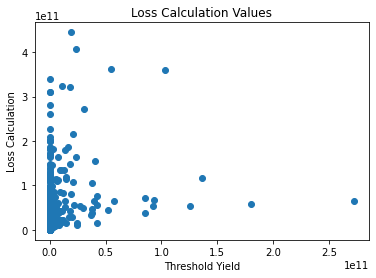

In [16]:
# View datapoints on plot charts
plt.scatter(df_cluster['threshold_yield'], df_cluster['loss_calculation'])
plt.title("Loss Calculation Values")
plt.xlabel("Threshold Yield")
plt.ylabel("Loss Calculation")
plt.show()

In [17]:
# Prepare dataset for clustering
mms = MinMaxScaler()
mms.fit(df_cluster[['loss_calculation']])
data_transformed = mms.transform(df_cluster[['loss_calculation']])

df_cluster['loss_calculation'] = data_transformed

mms.fit(df_cluster[['threshold_yield']])
data_transformed = mms.transform(df_cluster[['threshold_yield']])

df_cluster['threshold_yield'] = data_transformed

df_cluster

,ID,threshold_yield,loss_calculation,Average Temperature January (C),Average Temperature February (C),Average Temperature March (C),Average Temperature April (C),Average Temperature May (C),Average Temperature June (C),Average Temperature July (C),...,Average Sun Hours March,Average Sun Hours April,Average Sun Hours May,Average Sun Hours June,Average Sun Hours July,Average Sun Hours August,Average Sun Hours September,Average Sun Hours October,Average Sun Hours November,Average Sun Hours December
0,andhra pradesh_1_anantapur,0.009391,0.013688,24.3,26.9,30.2,32.3,31.7,28.5,27.2,...,10.7,11.1,11.1,9.2,8.3,7.9,8.4,8.6,8.0,8.1
1,andhra pradesh_1_chittoor,0.013217,0.037898,22.3,24.4,27.2,29.6,30.9,29.2,28.4,...,9.8,10.3,11.0,10.9,10.2,9.9,9.7,8.3,6.7,6.3
2,andhra pradesh_1_cuddapah,0.001068,0.062784,24.3,26.7,30.0,32.7,33.4,30.6,29.3,...,10.5,11.0,11.3,10.2,9.3,8.8,9.0,8.5,7.3,6.9
3,andhra pradesh_1_east godavari,0.023766,0.130029,23.8,25.3,27.8,29.9,31.9,30.4,28.6,...,9.5,9.5,10.2,10.6,10.1,9.7,9.0,8.7,8.9,8.7
4,andhra pradesh_1_guntur,0.003393,0.024240,24.2,26.1,28.7,31.0,33.3,31.3,29.4,...,9.1,9.6,10.8,11.0,10.4,9.8,9.2,8.5,8.2,7.8
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
574,west bengal_4_nadia,0.000303,0.108840,18.3,21.9,26.4,29.5,29.9,29.3,28.1,...,9.9,9.5,8.5,8.3,7.9,7.8,7.8,8.4,9.0,8.6
575,west bengal_4_north 24 parganas,0.000380,0.072109,19.0,22.7,27.0,29.8,30.4,29.4,28.1,...,9.7,9.5,8.7,8.5,8.1,7.8,7.9,8.3,8.9,8.7
576,west bengal_4_purba medinipur,0.000480,0.134470,19.4,23.1,27.3,30.1,30.8,29.8,28.3,...,9.8,9.8,9.3,9.2,8.5,8.1,8.1,8.4,8.9,8.8
577,west bengal_4_purulia,0.000197,0.065657,17.3,21.3,26.2,30.4,31.0,29.6,27.3,...,10.6,11.1,10.9,9.6,7.5,6.9,7.3,8.4,9.1,9.0


In [18]:
# Export csv before clustering for performance improvement
df_cluster.to_csv("datasets_preprocessed/df_kharif_preprocessed_to_cluster.csv", sep=';')

<b><u><i>For Rabi dataset</i></u></b>

In [19]:
# Prepare clustering datasets
ID_list = []

# Add identifier for clusters by most granular level desired
ID_features = granularity_features[0:granularity_features.index(most_granular_level)+1]
df_shorten("rabi")[ID_features] = df_shorten("rabi")[ID_features].astype(str)

for column in ID_features:
    ID_list = df_shorten("rabi")[ID_features].agg('_'.join, axis=1)

# Threshold Yield and Loss Calculation
threshold_yield_list = df_shorten("rabi")['Threshold Yield']
loss_calculation_list = df_shorten("rabi")['Loss Calculation']

additional_0 = df_shorten("rabi")['Average Temperature January (C)']
additional_1 = df_shorten("rabi")['Average Temperature February (C)']
additional_2 = df_shorten("rabi")['Average Temperature March (C)']
additional_3 = df_shorten("rabi")['Average Temperature April (C)']
additional_4 = df_shorten("rabi")['Average Temperature May (C)']
additional_5 = df_shorten("rabi")['Average Temperature June (C)']
additional_6 = df_shorten("rabi")['Average Temperature July (C)']
additional_7 = df_shorten("rabi")['Average Temperature August (C)']
additional_8 = df_shorten("rabi")['Average Temperature September (C)']
additional_9 = df_shorten("rabi")['Average Temperature October (C)']
additional_10 = df_shorten("rabi")['Average Temperature November (C)']
additional_11 = df_shorten("rabi")['Average Temperature December (C)']
additional_12= df_shorten("rabi")['Min. Temperature January (C)']
additional_13 = df_shorten("rabi")['Min. Temperature February (C)']
additional_14 = df_shorten("rabi")['Min. Temperature March (C)']
additional_15 = df_shorten("rabi")['Min. Temperature  April (C)']
additional_16 = df_shorten("rabi")['Min. Temperature May (C)']
additional_17 = df_shorten("rabi")['Min. Temperature June (C)']
additional_18 = df_shorten("rabi")['Min. Temperature July (C)']
additional_19 = df_shorten("rabi")['Min. Temperature August (C)']
additional_20 = df_shorten("rabi")['Min. Temperature September (C)']
additional_21 = df_shorten("rabi")['Min. Temperature October (C)']
additional_22 = df_shorten("rabi")['Min. Temperature November (C)']
additional_23 = df_shorten("rabi")['Min. Temperature December (C)']
additional_24 = df_shorten("rabi")['Max. Temperature January (C)']
additional_25 = df_shorten("rabi")['Max. Temperature February (C)']
additional_26 = df_shorten("rabi")['Max. Temperature March (C)']
additional_27 = df_shorten("rabi")['Max. Temperature April (C)']
additional_28 = df_shorten("rabi")['Max. Temperature May (C)']
additional_29 = df_shorten("rabi")['Max. Temperature June (C)']
additional_30 = df_shorten("rabi")['Max. Temperature July (C)']
additional_31 = df_shorten("rabi")['Max. Temperature August (C)']
additional_32 = df_shorten("rabi")['Max. Temperature September (C)']
additional_33 = df_shorten("rabi")['Max. Temperature October (C)']
additional_34 = df_shorten("rabi")['Max. Temperature November (C)']
additional_35 = df_shorten("rabi")['Max. Temperature December (C)']
additional_36 = df_shorten("rabi")['Precipitation January']
additional_37 = df_shorten("rabi")['Precipitation February']
additional_38 = df_shorten("rabi")['Precipitation March']
additional_39 = df_shorten("rabi")['Precipitation April']
additional_40 = df_shorten("rabi")['Precipitation May']
additional_41 = df_shorten("rabi")['Precipitation June']
additional_42 = df_shorten("rabi")['Precipitation July']
additional_43 = df_shorten("rabi")['Precipitation August']
additional_44 = df_shorten("rabi")['Precipitation September']
additional_45 = df_shorten("rabi")['Precipitation October']
additional_46 = df_shorten("rabi")['Precipitation November']
additional_47 = df_shorten("rabi")['Precipitation December']
additional_48 = df_shorten("rabi")['Humidity (%) January']
additional_49 = df_shorten("rabi")['Humidity (%) February']
additional_50 = df_shorten("rabi")['Humidity (%) March']
additional_51 = df_shorten("rabi")['Humidity (%) April']
additional_52 = df_shorten("rabi")['Humidity (%) May']
additional_53 = df_shorten("rabi")['Humidity (%) June']
additional_54 = df_shorten("rabi")['Humidity (%) July']
additional_55 = df_shorten("rabi")['Humidity (%) August']
additional_56 = df_shorten("rabi")['Humidity (%) September']
additional_57 = df_shorten("rabi")['Humidity (%) October']
additional_58 = df_shorten("rabi")['Humidity (%) November']
additional_59 = df_shorten("rabi")['Humidity (%) December']
additional_60 = df_shorten("rabi")['Rainy days (d) January']
additional_61 = df_shorten("rabi")['Rainy days (d) February']
additional_62 = df_shorten("rabi")['Rainy days (d) March']
additional_63 = df_shorten("rabi")['Rainy days (d) April']
additional_64 = df_shorten("rabi")['Rainy days (d) May']
additional_65 = df_shorten("rabi")['Rainy days (d) June']
additional_66 = df_shorten("rabi")['Rainy days (d) July']
additional_67 = df_shorten("rabi")['Rainy days (d) August']
additional_68 = df_shorten("rabi")['Rainy days (d) September']
additional_69 = df_shorten("rabi")['Rainy days (d) October']
additional_70 = df_shorten("rabi")['Rainy days (d) November']
additional_71 = df_shorten("rabi")['Rainy days (d) December']
additional_72 = df_shorten("rabi")['Average Sun Hours January']
additional_73 = df_shorten("rabi")['Average Sun Hours February']
additional_74 = df_shorten("rabi")['Average Sun Hours March']
additional_75 = df_shorten("rabi")['Average Sun Hours April']
additional_76 = df_shorten("rabi")['Average Sun Hours May']
additional_77 = df_shorten("rabi")['Average Sun Hours June']
additional_78 = df_shorten("rabi")['Average Sun Hours July']
additional_79 = df_shorten("rabi")['Average Sun Hours August']
additional_80 = df_shorten("rabi")['Average Sun Hours September']
additional_81 = df_shorten("rabi")['Average Sun Hours October']
additional_82 = df_shorten("rabi")['Average Sun Hours November']
additional_83 = df_shorten("rabi")['Average Sun Hours December']


data_tuples = list(zip(ID_list, threshold_yield_list, loss_calculation_list, 
                       additional_0, additional_1, additional_2, additional_3,
                       additional_4, additional_5, additional_6, additional_7,
                       additional_8, additional_9,
                       additional_10, additional_11, additional_12, additional_13,
                       additional_14, additional_15, additional_16, additional_17,
                       additional_18, additional_19,
                       additional_20, additional_21, additional_22, additional_23,
                       additional_24, additional_25, additional_26, additional_27,
                       additional_28, additional_29,
                       additional_30, additional_31, additional_32, additional_33,
                       additional_34, additional_35, additional_36, additional_37,
                       additional_38, additional_39,
                       additional_40, additional_41, additional_42, additional_43,
                       additional_44, additional_45, additional_46, additional_47,
                       additional_48, additional_49,
                       additional_50, additional_51, additional_52, additional_53,
                       additional_54, additional_55, additional_56, additional_57,
                       additional_58, additional_59,
                       additional_60, additional_61, additional_62, additional_63,
                       additional_64, additional_65, additional_66, additional_67,
                       additional_68, additional_69,
                       additional_70, additional_71, additional_72, additional_73,
                       additional_74, additional_75, additional_76, additional_77,
                       additional_78, additional_79,
                       additional_80, additional_81, additional_82, additional_83,
                      ))

df_cluster = pd.DataFrame(data_tuples,columns=['ID', 'threshold_yield', 'loss_calculation', 
                                               'Average Temperature January (C)', 'Average Temperature February (C)',
                                               'Average Temperature March (C)', 'Average Temperature April (C)',
                                               'Average Temperature May (C)', 'Average Temperature June (C)',
                                               'Average Temperature July (C)', 'Average Temperature August (C)',
                                               'Average Temperature September (C)', 'Average Temperature October (C)',
                                               'Average Temperature November (C)', 'Average Temperature December (C)',
                                               'Min. Temperature January (C)', 'Min. Temperature February (C)',
                                               'Min. Temperature March (C)', 'Min. Temperature  April (C)',
                                               'Min. Temperature May (C)', 'Min. Temperature June (C)',
                                               'Min. Temperature July (C)', 'Min. Temperature August (C)',
                                               'Min. Temperature September (C)', 'Min. Temperature October (C)',
                                               'Min. Temperature November (C)', 'Min. Temperature December (C)',
                                               'Max. Temperature January (C)', 'Max. Temperature February (C)',
                                               'Max. Temperature March (C)', 'Max. Temperature April (C)',
                                               'Max. Temperature May (C)', 'Max. Temperature June (C)',
                                               'Max. Temperature July (C)', 'Max. Temperature August (C)',
                                               'Max. Temperature September (C)', 'Max. Temperature October (C)',
                                               'Max. Temperature November (C)', 'Max. Temperature December (C)',
                                               'Precipitation January', 'Precipitation February',
                                               'Precipitation March', 'Precipitation April', 'Precipitation May',
                                               'Precipitation June', 'Precipitation July', 'Precipitation August',
                                               'Precipitation September', 'Precipitation October',
                                               'Precipitation November', 'Precipitation December',
                                               'Humidity (%) January', 'Humidity (%) February', 'Humidity (%) March',
                                               'Humidity (%) April', 'Humidity (%) May', 'Humidity (%) June',
                                               'Humidity (%) July', 'Humidity (%) August', 'Humidity (%) September',
                                               'Humidity (%) October', 'Humidity (%) November',
                                               'Humidity (%) December', 'Rainy days (d) January',
                                               'Rainy days (d) February', 'Rainy days (d) March',
                                               'Rainy days (d) April', 'Rainy days (d) May', 'Rainy days (d) June',
                                               'Rainy days (d) July', 'Rainy days (d) August',
                                               'Rainy days (d) September', 'Rainy days (d) October',
                                               'Rainy days (d) November', 'Rainy days (d) December',
                                               'Average Sun Hours January', 'Average Sun Hours February',
                                               'Average Sun Hours March', 'Average Sun Hours April',
                                               'Average Sun Hours May', 'Average Sun Hours June',
                                               'Average Sun Hours July', 'Average Sun Hours August',
                                               'Average Sun Hours September', 'Average Sun Hours October',
                                               'Average Sun Hours November', 'Average Sun Hours December'])

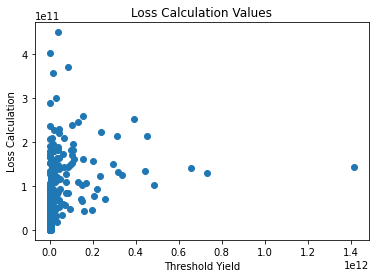

In [20]:
# View datapoints on plot charts
plt.scatter(df_cluster['threshold_yield'], df_cluster['loss_calculation'])
plt.title("Loss Calculation Values")
plt.xlabel("Threshold Yield")
plt.ylabel("Loss Calculation")
plt.show()

In [21]:
# Prepare dataset for clustering
mms = MinMaxScaler()
mms.fit(df_cluster[['loss_calculation']])
data_transformed = mms.transform(df_cluster[['loss_calculation']])

df_cluster['loss_calculation'] = data_transformed

mms.fit(df_cluster[['threshold_yield']])
data_transformed = mms.transform(df_cluster[['threshold_yield']])

df_cluster['threshold_yield'] = data_transformed

df_cluster

,ID,threshold_yield,loss_calculation,Average Temperature January (C),Average Temperature February (C),Average Temperature March (C),Average Temperature April (C),Average Temperature May (C),Average Temperature June (C),Average Temperature July (C),...,Average Sun Hours March,Average Sun Hours April,Average Sun Hours May,Average Sun Hours June,Average Sun Hours July,Average Sun Hours August,Average Sun Hours September,Average Sun Hours October,Average Sun Hours November,Average Sun Hours December
0,andhra pradesh_1.0_anantapur,0.001523,0.017028,24.3,26.9,30.2,32.3,31.7,28.5,27.2,...,10.7,11.1,11.1,9.2,8.3,7.9,8.4,8.6,8.0,8.1
1,andhra pradesh_1.0_east godavari,0.060844,0.185710,23.8,25.3,27.8,29.9,31.9,30.4,28.6,...,9.5,9.5,10.2,10.6,10.1,9.7,9.0,8.7,8.9,8.7
2,andhra pradesh_1.0_guntur,0.018902,0.068932,24.2,26.1,28.7,31.0,33.3,31.3,29.4,...,9.1,9.6,10.8,11.0,10.4,9.8,9.2,8.5,8.2,7.8
3,andhra pradesh_1.0_kurnool,0.003742,0.085053,24.6,27.0,30.3,32.7,33.1,29.2,27.5,...,10.6,11.1,11.3,9.4,8.4,8.0,8.1,8.8,8.6,8.8
4,andhra pradesh_1.0_prakasam,0.108780,0.575644,24.1,25.4,27.7,29.7,32.3,31.5,30.0,...,9.5,10.3,11.2,11.1,10.5,10.1,9.6,8.6,7.8,7.4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
483,west bengal_3.0_malda,0.000325,0.011637,17.5,20.8,25.5,28.5,28.9,28.9,28.2,...,10.1,8.7,7.4,7.1,7.3,7.5,7.4,8.5,8.9,8.3
484,west bengal_3.0_murshidabad,0.001167,0.071718,17.8,21.4,26.2,29.3,29.5,29.2,28.1,...,10.2,9.3,8.1,7.9,7.7,7.7,7.6,8.5,8.9,8.5
485,west bengal_3.0_nadia,0.000580,0.082268,18.3,21.9,26.4,29.5,29.9,29.3,28.1,...,9.9,9.5,8.5,8.3,7.9,7.8,7.8,8.4,9.0,8.6
486,west bengal_3.0_north 24 parganas,0.001026,0.048175,19.0,22.7,27.0,29.8,30.4,29.4,28.1,...,9.7,9.5,8.7,8.5,8.1,7.8,7.9,8.3,8.9,8.7


In [22]:
# Export csv before clustering for performance improvement
df_cluster.to_csv("datasets_preprocessed/df_rabi_preprocessed_to_cluster.csv", sep=';')